In [8]:
import copy
import seaborn as sns
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.ensemble import StackingClassifier
#from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import f1_score
from sklearn.utils import resample

from sklearn.preprocessing import PolynomialFeatures, PowerTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV  

RANDOM_SEED = 8    # Set a random seed for reproducibility!

In [2]:


pd.set_option("display.max_columns", 100)



train_df = pd.read_csv(
    "train.csv", 
    index_col="tripid"
)
test_features_df = pd.read_csv(
    "test.csv", 
    index_col="tripid"
)

labels_df = train_df[['label']]
features_df = train_df.drop('label', axis=1)

labels_df=labels_df.replace("correct", 1)
labels_df=labels_df.replace("incorrect", 0)
labels_df
print("labels_df.shape", labels_df.shape)
labels_df.head()

labels_df.shape (17176, 1)


,label
tripid,
189123628,1
189125358,1
189125719,1
189127273,1
189128020,1


In [266]:
def hoursToMin(time):
    return 60*time.hour + time.minute

def convertTime(dataFrame):
    new_df = copy.deepcopy(dataFrame)
    
    new_df["effective_time"] = dataFrame["duration"]-dataFrame["meter_waiting"]
    
    new_df['pickup_time'] = dataFrame['pickup_time'].astype('datetime64[m]')
    new_df['drop_time'] = dataFrame['drop_time'].astype('datetime64[m]')
    
    new_df['pickup_time'] = new_df['pickup_time'].apply(lambda x : hoursToMin(x))
    new_df['drop_time'] = new_df['drop_time'].apply(lambda x : hoursToMin(x))
    new_df = new_df.drop(['pickup_time', 'drop_time'], axis=1)
    return new_df

# Custom transformer
timeTransformer = FunctionTransformer(convertTime)

In [267]:
import math

def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a)) 

def createDistanace(dataFrame):
    new_df = copy.deepcopy(dataFrame)
    new_df["distance"] = distance(dataFrame['pick_lat'], dataFrame['pick_lon'], dataFrame['drop_lat'], dataFrame['drop_lon'])
    new_df = new_df.drop(['pick_lat', 'pick_lon', 'drop_lat', 'drop_lon'], axis=1)
    return new_df
    
df = createDistanace(features_df)
df.head()

distanceTransformer = FunctionTransformer(createDistanace)

In [268]:
features_eng_df = convertTime(createDistanace(features_df))
joined_df = features_eng_df.join(labels_df)

joined_df.head()

,additional_fare,duration,meter_waiting,meter_waiting_fare,meter_waiting_till_pickup,fare,distance,effective_time,label
tripid,,,,,,,,,
189123628,10.5,834.0,56.0,0.0000,64.0,270.32,3.164501,778.0,1
189125358,10.5,791.0,47.0,0.0000,134.0,197.85,1.968540,744.0,1
189125719,10.5,1087.0,80.0,0.0000,61.0,301.64,3.917991,1007.0,1
189127273,10.5,598.0,271.0,15.6638,68.0,82.30,0.535588,327.0,1
189128020,NaN,NaN,NaN,NaN,NaN,358.39,5.062797,NaN,1


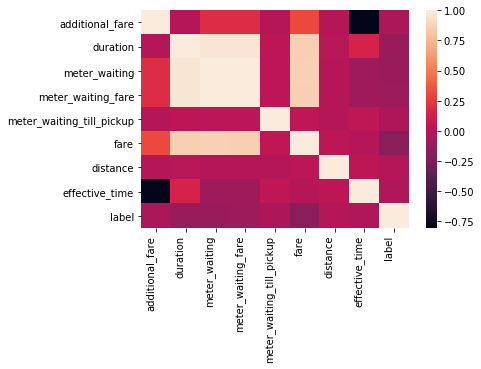

In [269]:
correlations = joined_df.corr()

ax = sns.heatmap(
    correlations, 
    #vmin=-1, vmax=1, center=0,
    #cmap=sns.diverging_palette(20, 220, n=200),
    #square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

#features_df.drop(['meter_waiting', 'meter_waiting_fare'], axis=1)

In [270]:
est_mlp = MLPClassifier(hidden_layer_sizes=(200,100,), learning_rate='invscaling', learning_rate_init=0.01,
                          power_t=0.5, max_iter=500, shuffle=True, tol=0.0001, 
                          early_stopping=True, validation_fraction=0.1, n_iter_no_change=10, max_fun=15000,
                         random_state=RANDOM_SEED)
est_xgb = XGBClassifier(max_depth=5, min_child_weight=1, gamma=0, reg_lambda=30, reg_alpha=0)
est_gb = GradientBoostingClassifier(random_state=8, n_estimators=250)
est_rn = RandomForestClassifier(max_depth=10, bootstrap=True, n_estimators=200)
est_svc = SVC()
est_nb = GaussianNB()
est_kn = KNeighborsClassifier()

estimators_stacked = [('xbg', est_xgb),
              ('mlp', est_mlp),
              #('gb', est_gb),
              #('rn', est_rn)
             ]

stacked_estimator =  StackingClassifier(estimators=estimators_stacked,
                                    final_estimator=LogisticRegression(),
                                    stack_method='predict_proba'
                                  )

In [271]:
seperate_processing_cols = []

numeric_cols = features_df.columns.values
numeric_cols = [x for x in numeric_cols if (x not in seperate_processing_cols)]
#numeric_cols = features_df.columns[features_df.dtypes != "object"].values
# chain preprocessing into a Pipeline object
# each step is a tuple of (name you chose, sklearn transformer)

preprocessor = Pipeline([
    ('date_converter', timeTransformer),
    ('distance', distanceTransformer),
    ('simple_imputer', SimpleImputer(strategy='mean')),
    #('feature_selector', SelectKBest(score_func=chi2, k=5)),
    ('standard_scaler', StandardScaler()),
    #('sample', SMOTE(random_state=RANDOM_SEED, sampling_strategy=0.8)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.2, random_state=17)), # random_state=17 provides best sampling
    #('basis expansion', PolynomialFeatures(2)),
    ("estimator", stacked_estimator)
])

In [272]:
full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
])


#splitting the dataset
X_train, X_eval, y_train, y_eval = train_test_split(
    features_df,
    labels_df,
    test_size=0.33,
    shuffle=True,
    stratify=labels_df,
    random_state=RANDOM_SEED
)


full_pipeline.fit(X_train, y_train.values.ravel())
print("Training done")

Training done


In [273]:
y_pred_train= full_pipeline.predict(X_train)
y_pred= full_pipeline.predict(X_eval)

In [274]:
f1_score(y_train, y_pred_train, average=None)

array([0.81450488, 0.98087523])

In [275]:
f1_score(y_eval, y_pred, average=None)

array([0.77010407, 0.97636417])

In [203]:
for i in range(20):
    preprocessor = Pipeline([
    ('date_converter', timeTransformer),
    ('distance', distanceTransformer),
    ('simple_imputer', SimpleImputer(strategy='mean')),
    #('feature_selector', SelectKBest(score_func=chi2, k=5)),
    ('standard_scaler', StandardScaler()),
    #('sample', SMOTE(random_state=RANDOM_SEED, sampling_strategy=0.8)),
    ('undersample', RandomUnderSampler(sampling_strategy=0.2, random_state=i)),
    #('basis expansion', PolynomialFeatures(2)),
    ("estimator", est_mlp)
    ])
    full_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ])
    full_pipeline.fit(X_train, y_train.values.ravel())
    
    y_pred_train= full_pipeline.predict(X_train)
    y_pred= full_pipeline.predict(X_eval)
    
    print("Random state: ", i)
    print("Train: ", f1_score(y_train, y_pred_train, average=None))
    print("Eval: ", f1_score(y_eval, y_pred, average=None))

Random state:  0
Train:  [0.74568362 0.97388721]
Eval:  [0.74074074 0.97345649]
Random state:  1
Train:  [0.76164384 0.97493277]
Eval:  [0.75816993 0.97477355]
Random state:  2
Train:  [0.76943942 0.97548313]
Eval:  [0.75386013 0.9735274 ]
Random state:  3
Train:  [0.7740113 0.9770225]
Eval:  [0.75980861 0.9756145 ]
Random state:  4
Train:  [0.74704077 0.97216997]
Eval:  [0.76088889 0.97366102]
Random state:  5
Train:  [0.77562327 0.97668841]
Eval:  [0.75680751 0.97478828]
Random state:  6
Train:  [0.74829932 0.97332885]
Eval:  [0.7438914  0.97234438]
Random state:  7
Train:  [0.78699038 0.9776775 ]
Eval:  [0.75489282 0.97437896]
Random state:  8
Train:  [0.78319177 0.97665688]
Eval:  [0.75583483 0.97339593]
Random state:  9
Train:  [0.75531011 0.97212004]
Eval:  [0.74398625 0.97070965]
Random state:  10
Train:  [0.77001388 0.9761665 ]
Eval:  [0.76119403 0.97506332]
Random state:  11
Train:  [0.77457705 0.9763288 ]
Eval:  [0.75492958 0.97459359]
Random state:  12
Train:  [0.76852699 0.

In [ ]:
param_rn = {'preprocessor__estimator__bootstrap': [True, False],
 'preprocessor__estimator__max_depth': [ 6, 7, 8, 9, 10, 11, 12, None],
 #'preprocessor__estimator__max_features': ['auto', 'sqrt'],
 #'preprocessor__estimator__min_samples_leaf': [1, 2, 4],
 #'preprocessor__estimator__min_samples_split': [2, 5, 10],
 'preprocessor__estimator__n_estimators': [200, 400, 600, 800]
}

param_test1 = {

 'preprocessor__estimator__min_child_weight':range(1,6,2)
}

param_test2 = {
 'preprocessor__estimator__gamma':[i/10.0 for i in range(0,5)]
}

param_test3 = {
 'preprocessor__estimator__max_depth':range(3,7,1),
 'preprocessor__estimator__reg_alpha': range(0,50,8),
 'preprocessor__estimator__reg_lambda': range(0,50,8)
}

param_opt = GridSearchCV(estimator=full_pipeline, param_grid=param_rn, scoring='f1', verbose=10)
param_opt.fit(X_train, y_train.values.ravel())

In [17]:
param_opt.best_params_

{'preprocessor__estimator__bootstrap': True,
 'preprocessor__estimator__max_depth': None,
 'preprocessor__estimator__n_estimators': 200}

In [277]:
%%time 

full_pipeline.fit(features_df, labels_df.values.ravel())

None   # So we don't print out the whole pipeline representation

Wall time: 2min 32s


In [279]:
test_score = full_pipeline.predict(test_features_df)
test_score

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [280]:
test_score.shape

(8576,)

In [281]:
y_preds = pd.DataFrame(
    {
        # "label": test_score1[:,0],
        "label": test_score,
    },
    index = test_features_df.index
)
print("y_preds.shape:", y_preds.shape)
y_preds.head()

y_preds.shape: (8576, 1)


,label
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1


In [282]:
submission_df = pd.read_csv("sample_submission.csv", 
                            index_col="tripid")

In [283]:
submission_df.head()

,prediction
tripid,
213284604,1
213286352,0
213293973,0
213294622,1
213298687,1


In [284]:
# Make sure we have the rows in the same order
np.testing.assert_array_equal(test_features_df.index.values, 
                              submission_df.index.values)

In [285]:
# Save predictions to submission data frame
submission_df["prediction"] = test_score

submission_df.head()

,prediction
tripid,
213284604,1
213286352,1
213293973,1
213294622,1
213298687,1


In [286]:
submission_df.to_csv('my_submission13.csv', index=True)